# Autocodificador Variacional Convolucional: Conv-VAE

# Librerías


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import os
from glob import glob
import numpy as np

gpu_available = tf.config.list_physical_devices('GPU')
print(gpu_available)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# BD: CelebA Dataset

Descargamos los datos y atributos desde la carpeta de Google Drive.

In [1]:
#Censored

# Parámetros Globales

In [ ]:
# Parámetros de datos
DATA_FOLDER   = './datos/img_align_celeba'
INPUT_DIM     = (128,128,3) #tamaño de la imágen
LATENT_DIM    = 150

# Dimesiones del encoder/decorder
ENC_LABEL_DIM = 10
DEC_LABEL_DIM = 10

#Parámetros de entrenamiento
BATCH_SIZE    = 384
R_LOSS_FACTOR = 10000
EPOCHS        = 50 #400
INITIAL_EPOCH = 0

filenames       = np.array(glob(os.path.join(DATA_FOLDER, '*.jpg')))
n_images        = filenames.shape[0]
steps_per_epoch = n_images//BATCH_SIZE

print('num image files : ', n_images)
print('steps per epoch : ', steps_per_epoch)

num image files :  202599
steps per epoch :  527


# Obtenemos los vectores de etiquetas y las imágenes.

In [ ]:
LABELS_FILE = './datos/list_attr_celeba.txt'

In [ ]:
with open(LABELS_FILE) as f:
      contents = f.readlines()

Ejemplo

In [ ]:
contents[:10]

['202599\n',
 '5_o_Clock_Shadow Arched_Eyebrows Attractive Bags_Under_Eyes Bald Bangs Big_Lips Big_Nose Black_Hair Blond_Hair Blurry Brown_Hair Bushy_Eyebrows Chubby Double_Chin Eyeglasses Goatee Gray_Hair Heavy_Makeup High_Cheekbones Male Mouth_Slightly_Open Mustache Narrow_Eyes No_Beard Oval_Face Pale_Skin Pointy_Nose Receding_Hairline Rosy_Cheeks Sideburns Smiling Straight_Hair Wavy_Hair Wearing_Earrings Wearing_Hat Wearing_Lipstick Wearing_Necklace Wearing_Necktie Young \n',
 '000001.jpg -1  1  1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1  1  1 -1  1 -1 -1  1 -1 -1  1 -1 -1 -1  1  1 -1  1 -1  1 -1 -1  1\n',
 '000002.jpg -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1 -1  1 -1 -1  1 -1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1  1\n',
 '000003.jpg -1 -1 -1 -1 -1 -1  1 -1 -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1  1 -1 -1  1 -1 -1 -1 -1 -1  1 -1 -1 -1 -1 -1  1\n',
 '000004.jpg -1 -1  1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  1 -1 -1  1 -1 -1 -1

Extraemos las etiquetas de cada imagen.

In [ ]:
def etiquetas (LABELS_FILE) :
    #Leemos el archivo
    with open(LABELS_FILE) as f:
      contents = f.readlines()
      #Obtenemos los nombres de los atributos
      names = contents[1].split(' ')
      #Aislamos los nombres
      contents = [content.split('\n')[0] for content in contents[2:]]
      

      ids    = []
      labels = []
      for line in contents :
        tmp = line.split(' ')
        ids.append(tmp[0])
        labels.append(tmp[1:])

      t_labels = []

      for id, label in zip(ids,labels) :
        t_labels.append([x for x in label if x]) #Obtenemos las etiquetas no vacías

    return names[:-1], np.array(t_labels, dtype = np.float32)

Obtenemos los nombres de los atributos y las etiquetas.

In [ ]:
names, labels = etiquetas(LABELS_FILE)

In [ ]:
print(names)

['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive', 'Bags_Under_Eyes', 'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby', 'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup', 'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair', 'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick', 'Wearing_Necklace', 'Wearing_Necktie', 'Young']


In [ ]:
print(labels)

[[-1.  1.  1. ... -1. -1.  1.]
 [-1. -1. -1. ... -1. -1.  1.]
 [-1. -1. -1. ... -1. -1.  1.]
 ...
 [-1. -1. -1. ... -1. -1.  1.]
 [-1.  1.  1. ... -1. -1.  1.]
 [-1.  1.  1. ... -1. -1.  1.]]


In [ ]:
labels.shape

(202599, 40)

# Cargamos la base de datos Celeba

In [ ]:
DATA_FOLDER   = './datos/img_align_celeba/'

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
dataset = tf.keras.utils.image_dataset_from_directory(directory  = DATA_FOLDER, 
                                                      labels     = None,
                                                      batch_size = 1, 
                                                      image_size = INPUT_DIM[:2],
                                                      shuffle    = False,)

dataset = dataset.prefetch(buffer_size=AUTOTUNE)

normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)
dataset = dataset.map(lambda x: (normalization_layer(x)), num_parallel_calls=AUTOTUNE)

Found 202599 files belonging to 1 classes.


In [ ]:
label_dataset = tf.data.Dataset.from_tensor_slices(labels)
merge_dataset = tf.data.Dataset.zip((dataset.unbatch(), label_dataset))
merge_dataset = merge_dataset.batch(BATCH_SIZE).repeat()

In [ ]:
for img, lab in merge_dataset.take(1) :
    print(img.shape, lab.shape)

(384, 128, 128, 3) (384, 40)


Mostramos un lote de la BD.

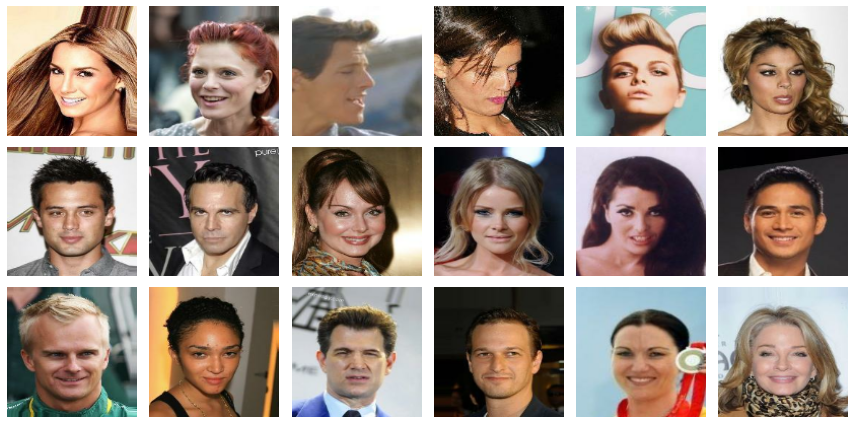

TensorShape([384, 128, 128, 3])

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), tight_layout=True)
    
for images, _ in merge_dataset.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy())
        plt.axis('off')

plt.show()
        
images.shape 

# Autoencoder


In [ ]:
from tensorflow import keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Flatten, Reshape, Dropout, BatchNormalization, Activation, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential

In [ ]:
len(labels[0])

40

## Encoder

En el encoder, agregamos la dimensión de las etiquetas, y pasamos las etiquetas por una capa densa, y luego concatenamos con las imágenes.

In [ ]:
class Encoder(keras.Model):
    def __init__(self, input_dim, output_dim, label_dim,
                 encoder_conv_filters, encoder_conv_kernel_size, encoder_conv_strides, 
                 use_batch_norm=True, use_dropout=True, **kwargs): #Parámetros del encoder
        '''
        '''
        super(Encoder, self).__init__(**kwargs)

        self.input_dim                 = input_dim
        self.output_dim                = output_dim


        #Dimensión de las etiquetas
        self.label_dim                 = label_dim
      
        self.encoder_conv_filters      = encoder_conv_filters
        self.encoder_conv_kernel_size  = encoder_conv_kernel_size
        self.encoder_conv_strides      = encoder_conv_strides
        self.n_layers_encoder          = len(self.encoder_conv_filters)
        self.use_batch_norm            = use_batch_norm
        self.use_dropout               = use_dropout

        self.model = self.encoder_model()
        self.built = True
             
    def get_config(self):
        config = super(Encoder, self).get_config()
        config.update({"units": self.units})
        return config
    
    def encoder_model(self):
        '''
        '''
        encoder_input = layers.Input(shape = self.input_dim, name ='encoder')
        label         = layers.Input(shape = 40, name = 'label')

        x = encoder_input
        
        for i in range(self.n_layers_encoder):            
            x = Conv2D(filters     = self.encoder_conv_filters[i],
                       kernel_size = self.encoder_conv_kernel_size[i],
                       strides     = self.encoder_conv_strides[i],
                       padding     = 'same',
                       name        = 'encoder_conv_' + str(i),)(x)
            if self.use_batch_norm: 
                x = BatchNormalization()(x)
            x = LeakyReLU()(x)
            if self.use_dropout:    
                x = Dropout(rate = 0.25)(x)
                
        self.last_conv_size = x.shape[1:]
        x     = Flatten()(x)
        #Primera entrada x_real 
        y_1 = Dense(self.output_dim)(x) 
#________________________________________________________Modificación__________________________________-

        # Agregamos la otra, respecto a v_real pasandola por una capa densa
        y_2 = Dense(self.label_dim, name = 'v_real')(label)

        #Concatenamos las salidas
        encoder_output = layers.Concatenate()([y_1, y_2])
        
        #Definición de modelo concatenado
        model = keras.Model([encoder_input, label], encoder_output)
        return model
        
        
    def call(self, inputs):
        '''
        '''
        img, label = inputs
        return self.model([img, label]) 

## Decoder

En la parte del decoder, pasamos las etiquetas directamente y concatenamos con la salida del encoder.

In [ ]:
class Decoder(keras.Model):
    def __init__(self, input_dim, input_conv_dim, label_dim,
                 decoder_conv_t_filters, decoder_conv_t_kernel_size, decoder_conv_t_strides, 
                 use_batch_norm=True, use_dropout=True, **kwargs):

        '''
        '''
        super(Decoder, self).__init__(**kwargs)

        self.input_dim                 = input_dim
        self.input_conv_dim            = input_conv_dim

        self.label_dim                 = label_dim
                
        self.decoder_conv_t_filters    = decoder_conv_t_filters 
        self.decoder_conv_t_kernel_size= decoder_conv_t_kernel_size
        self.decoder_conv_t_strides    = decoder_conv_t_strides
        self.n_layers_decoder          = len(self.decoder_conv_t_filters)
        
        self.use_batch_norm            = use_batch_norm
        self.use_dropout               = use_dropout

        self.model = self.decoder_model()
        self.built = True
             
    def get_config(self):
        config = super(Decoder, self).get_config()
        config.update({"units": self.units})
        return config
    
    def decoder_model(self):
        '''
        '''    
        decoder_input = layers.Input(shape = self.input_dim, name='decoder' )
        #---------------------Etiquetas--------------------------------------
        label         = layers.Input(shape = 40, name='label')
        #__________________Modfificación_____________________________
        x              =layers.Concatenate()([decoder_input, label])
        #-------- ------------------------------------------------------
        x = Dense(np.prod(self.input_conv_dim))(x)
        x = Reshape(self.input_conv_dim)(x)

        for i in range(self.n_layers_decoder):
            x = Conv2DTranspose(filters     = self.decoder_conv_t_filters[i],
                                kernel_size = self.decoder_conv_t_kernel_size[i],
                                strides     = self.decoder_conv_t_strides[i],
                                padding     = 'same',
                                name        = 'decoder_conv_t_' + str(i))(x)
            if i < self.n_layers_decoder - 1:

                if self.use_batch_norm:   
                    x = BatchNormalization()(x)
                x = LeakyReLU()(x)
                if self.use_dropout:      
                    x = Dropout(rate = 0.25)(x)
            else:
                x = Activation('sigmoid')(x)
        #_______________________Modificación__________________
        #Obtenemos la salida ya pasada por la densa y convolucional
        decoder_output = x
        #Concatenamos la entrada
        model = keras.Model([decoder_input, label], decoder_output)
        return model
        
    def call(self, inputs):
        '''
        '''
        return self.model(inputs) 

# Generamos rostros a partir del autoencoder


#Muestreo

In [ ]:
  class Sampler(keras.Model):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def __init__(self, latent_dim,  **kwargs):
        super(Sampler, self).__init__(**kwargs)
        #----------Aumentamos la dimensión-------
        self.latent_dim = latent_dim + 10 
        self.model      = self.sampler_model()
        self.built      = True

    def get_config(self):
        config = super(Sampler, self).get_config()
        config.update({"units": self.units})
        return config
    
    def sampler_model(self):
        '''
        input_dim is a vector in the latent (codified) space
        '''
        input_data = layers.Input(shape=self.latent_dim)
        z_mean     = Dense(self.latent_dim, name="z_mean")(input_data)
        z_log_var  = Dense(self.latent_dim, name="z_log_var")(input_data)

        self.batch = tf.shape(z_mean)[0] 
        self.dim   = tf.shape(z_mean)[1]

        epsilon = tf.keras.backend.random_normal(shape=(self.batch, self.dim))
        z = z_mean + tf.exp(0.5 * z_log_var) * epsilon
        model = keras.Model(input_data, [z, z_mean, z_log_var])
        return model
        
    def call(self, inputs):
        '''
        '''
        return self.model(inputs)

# Variational Autoencoder Condicionado (VAE)

Esquema

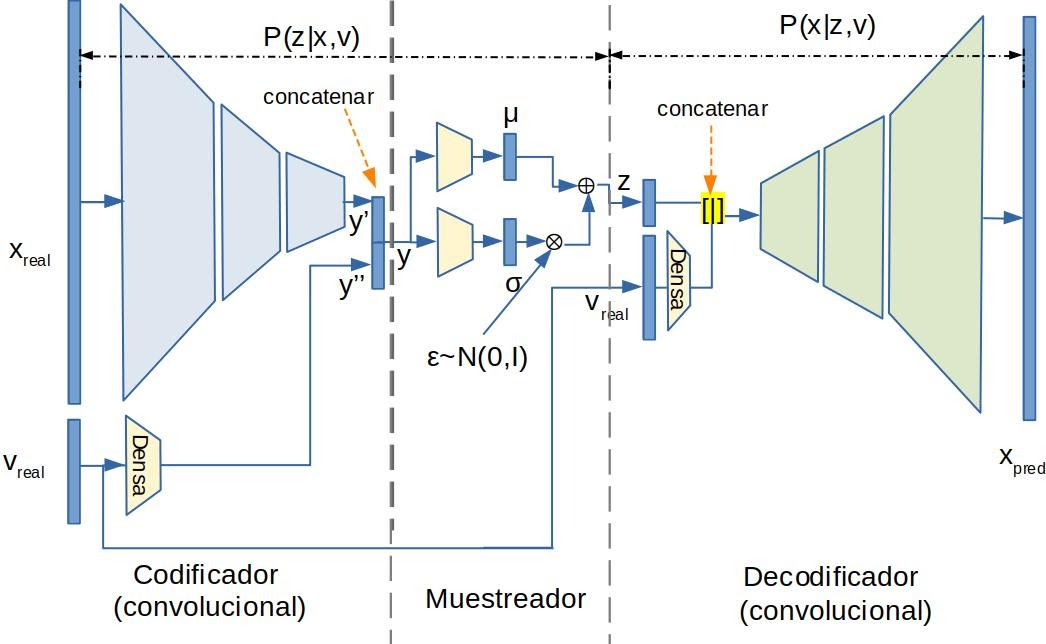

In [ ]:
class VAE(keras.Model):
    def __init__(self, r_loss_factor=1, summary=False, **kwargs):
        super(VAE, self).__init__(**kwargs)

        self.r_loss_factor             = r_loss_factor

        #------------------------------------------------
        self.input_dim                 = INPUT_DIM
        self.latent_dim                = LATENT_DIM

        self.encoder_label_dim         = ENC_LABEL_DIM
        self.decoder_label_dim         = 40

        self.encoder_conv_filters      = [64,64,64,64]
        self.encoder_conv_kernel_size  = [3,3,3,3]
        self.encoder_conv_strides      = [2,2,2,2]
        self.n_layers_encoder          = len(self.encoder_conv_filters)

        self.decoder_conv_t_filters    = [64,64,64,3]
        self.decoder_conv_t_kernel_size= [3,3,3,3]
        self.decoder_conv_t_strides    = [2,2,2,2]
        self.n_layers_decoder          = len(self.decoder_conv_t_filters)

        self.use_batch_norm            = True
        self.use_dropout               = True
    
        self.total_loss_tracker          = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker             = tf.keras.metrics.Mean(name="kl_loss")
        self.mae                         = tf.keras.losses.MeanAbsoluteError()

        #-------------- Encoder---------------------------
        self.encoder_model = Encoder(input_dim                = self.input_dim,
                                     output_dim               = self.latent_dim,
                                     label_dim                = self.encoder_label_dim,
                                     encoder_conv_filters     = self.encoder_conv_filters, 
                                     encoder_conv_kernel_size = self.encoder_conv_kernel_size, 
                                     encoder_conv_strides     = self.encoder_conv_strides, 
                                     use_batch_norm           = self.use_batch_norm, 
                                     use_dropout              = self.use_dropout)
        
        self.encoder_conv_size = self.encoder_model.last_conv_size
        if summary: 
            self.encoder_model.summary()
        
        #---------------------Sampler-----------------------
        self.sampler_model = Sampler(latent_dim  = self.latent_dim)     
        if summary: 
            self.sampler_model.summary()

        #----------------------Decoder------------------------
        self.decoder_model = Decoder(input_dim                 = self.latent_dim + 10, 
                                     input_conv_dim            = self.encoder_conv_size,
                                     label_dim                 = self.decoder_label_dim,
                                     decoder_conv_t_filters    = self.decoder_conv_t_filters,
                                     decoder_conv_t_kernel_size= self.decoder_conv_t_kernel_size, 
                                     decoder_conv_t_strides    = self.decoder_conv_t_strides, 
                                     use_batch_norm            = self.use_batch_norm, 
                                     use_dropout               = self.use_dropout)
        print('Decoder pass')
        if summary: self.decoder_model.summary()
        
        self.built = True

    @property
    def metrics(self):
        return [self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,]

    @tf.function
    def train_step(self, data):
        '''
        Proceso en entrenamiento
        '''
        
        with tf.GradientTape() as tape:
            
            #---------------predict------------------------
            x                    = self.encoder_model([data[0], data[1]])
            z, z_mean, z_log_var = self.sampler_model(x) 
            pred                 = self.decoder_model([z, data[1]])

            #---------------loss--------------------------
            r_loss     = self.r_loss_factor * self.mae(data[0], pred)
            kl_loss    = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss    = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = r_loss + kl_loss
        
        # gradient
        grads = tape.gradient(total_loss, self.trainable_weights)
        # train step
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        # compute progress
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(r_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {"loss":                self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss":             self.kl_loss_tracker.result(),}
    
    @tf.function
    def generate(self, z_sample, label): #<-------------------------- Ahora consideramos las etiquetas también
        '''
        We use the sample of the N(0,I) directly as  
        input of the deterministic generator. 
        '''
        #Regresamos el valor de z concatenado con las etiquetas.
        return self.decoder_model([z_sample, label])

    @tf.function
    def codify(self, images, label): #<---------------------------------Ahora consideramos las etiquetas también
        '''
        For an input image we obtain its particular distribution:
        its mean, its variance (unvertaintly) and a sample z of such distribution.
        '''
        x = self.encoder_model.predict(images, label)
        z, z_mean, z_log_var= self.sampler_model(x)

        #------valores estimados---------
        return z, z_mean, z_log_var
    
    #-----------Implementación del método de llamado---------------------
    @tf.function
    def call(self, inputs, training=False):
        '''
        _____________Modificación en la llamada del modelo_________________ 
        '''   
        #--------------Imágenes y Etiquetas---------------
        img, label = inputs.get_single_element()
                
        tmp1, tmp2 = self.encoder_model.use_dropout,self.decoder_model.use_dropout
        if not training:
            self.encoder_model.use_dropout, self.decoder_model.use_dropout = False,False

        x                    = self.encoder_model([img, label])#<--------Introducimos al encoder la concatenación de las imágenes con etiquetas
        z, z_mean, z_log_var = self.sampler_model(x)  # Muestreamos estimando los parámetros de la distribución
        pred                 = self.decoder_model([z, label]) #<--Generamos usando el decoder, de nuevo concatenando el valor muestreado, con las etiquetas
        
        self.encoder_model.use_dropout, self.decoder_model.use_dropout = tmp1, tmp2
        return pred

# Entrenamiento

## Compile

In [ ]:
vae = VAE(r_loss_factor=R_LOSS_FACTOR, summary=True)

Model: "encoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_3 (Functional)         (None, 160)               728560    
Total params: 728,560
Trainable params: 728,048
Non-trainable params: 512
_________________________________________________________________
Model: "sampler_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_4 (Functional)         [(None, 160), (None, 160) 51520     
Total params: 51,520
Trainable params: 51,520
Non-trainable params: 0
_________________________________________________________________
Decoder pass
Model: "decoder_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_5 (Functional)         (None, 128, 128, 3)       936579    
Total params: 936,579
Trainable params: 936,195
Non-trainabl

In [ ]:
vae.summary()

Model: "vae_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  728560    
_________________________________________________________________
sampler_1 (Sampler)          multiple                  51520     
_________________________________________________________________
decoder_1 (Decoder)          multiple                  936579    
Total params: 1,716,665
Trainable params: 1,715,763
Non-trainable params: 902
_________________________________________________________________


In [ ]:
vae.compile(optimizer=keras.optimizers.Adam())

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

filepath = '/content/drive/MyDrive/Colab Notebooks/DeepLearning/best_weight_model.h5'

checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only=True,
                             save_weights_only=True,
                             mode='min')
callbacks = [checkpoint]

In [ ]:
vae.fit(merge_dataset, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS,
        initial_epoch   = INITIAL_EPOCH,
        steps_per_epoch = steps_per_epoch,
        callbacks       = callbacks)

Epoch 1/30
527/527 [==============================] - 439s 830ms/step - loss: 1500.6471 - reconstruction_loss: 1076.9307 - kl_loss: 98.7211

Epoch 00001: loss improved from inf to 1175.65125, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/best_weight_model.h5
Epoch 2/30
527/527 [==============================] - 443s 839ms/step - loss: 897.3700 - reconstruction_loss: 761.5630 - kl_loss: 114.6699

Epoch 00002: loss improved from 1175.65125 to 876.23273, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/best_weight_model.h5
Epoch 3/30
527/527 [==============================] - 441s 838ms/step - loss: 838.9249 - reconstruction_loss: 713.7190 - kl_loss: 117.1734

Epoch 00003: loss improved from 876.23273 to 830.89282, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/best_weight_model.h5
Epoch 4/30
527/527 [==============================] - 442s 838ms/step - loss: 815.6983 - reconstruction_loss: 692.6412 - kl_loss: 119.0313

Epoch 00

Cargamos los pesos del último entrenamiento.

In [ ]:
gdd.download_file_from_google_drive(file_id   = '1-6gpoSP8f0YO6pONcx5VIifvuRAaLz5r',
                                    dest_path = './datos/best_weight_model.h5',
                                    unzip     = False,
                                    showsize=True)

Ahora volvemos a cargar el modelo, y usamos los pesos obtenidos anteriormente.

In [ ]:
vae.load_weights('./datos/best_weight_model.h5')

Continuamos con el entrenamiento

In [ ]:
vae.fit(merge_dataset, 
        batch_size      = BATCH_SIZE,
        epochs          = EPOCHS - 16,
        initial_epoch   = INITIAL_EPOCH,
        steps_per_epoch = steps_per_epoch,
        callbacks       = callbacks,)

Epoch 1/34
527/527 [==============================] - 461s 814ms/step - loss: 774.2553 - reconstruction_loss: 616.5900 - kl_loss: 132.3493

Epoch 00001: loss improved from inf to 748.93951, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/best_weight_model.h5
Epoch 2/34
527/527 [==============================] - 432s 819ms/step - loss: 741.0495 - reconstruction_loss: 607.9065 - kl_loss: 132.7494

Epoch 00002: loss improved from 748.93951 to 740.65662, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/best_weight_model.h5
Epoch 3/34
527/527 [==============================] - 429s 815ms/step - loss: 740.2853 - reconstruction_loss: 606.4651 - kl_loss: 132.9940

Epoch 00003: loss improved from 740.65662 to 739.45959, saving model to /content/drive/MyDrive/Colab Notebooks/DeepLearning/best_weight_model.h5
Epoch 4/34
527/527 [==============================] - 428s 813ms/step - loss: 740.1750 - reconstruction_loss: 606.0341 - kl_loss: 133.2424

Epoch 00004

In [ ]:
vae2 = VAE(r_loss_factor=R_LOSS_FACTOR)

Decoder pass


In [ ]:
vae2.load_weights('./datos/best_weight_model.h5')

# Resultados

Generamos un vector de atributos aleatorios.

In [ ]:
def random_label () :
  tam = 40
  label = np.random.randint(-1, 1, size = (1, tam))
  for i in range(label.shape[1]) :
    if label[0][i] == 0 :
      label[0][i] = 1

  return label

Ejemplo de vector de atributos generados aleatoriamente.

In [ ]:
random_label()

array([[-1,  1,  1, -1,  1, -1, -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,
        -1,  1, -1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,
         1, -1, -1, -1,  1, -1, -1, -1]])

In [ ]:
import matplotlib.pyplot as plt

def plot_latent_space(vae, input_size = (28,28,1), n = 30, figsize = 15,  scale = 1., latents_start = [0,1], label=random_label()):
    # display a n*n 2D manifold of digits
    canvas = np.zeros((input_size[0]*n, input_size[1]*n, input_size[2]))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    z_sample = np.random.normal(0,1,(1,vae.latent_dim))

    #--------------------------------Modificación-----------------------------
    encod     = vae.encoder_model([np.zeros((1, 128, 128, 3)), label])
    label_enc = np.expand_dims(encod[0][150:], axis = 0)
    z_sample = np.concatenate((z_sample, label_enc), axis = 1)
    #________________________________________________________________________

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample[0][latents_start[0]], z_sample[0][latents_start[1]]=xi,yi
            x_decoded = vae.generate(z_sample,label)
            img = x_decoded[0].numpy().reshape(input_size)
            canvas[i*input_size[0] : (i + 1)*input_size[0],
                   j*input_size[1] : (j + 1)*input_size[1],
                   : ] = img

    plt.figure(figsize=(figsize, figsize))
    start_range    = input_size[0] // 2
    end_range      = n*input_size[0] + start_range
    pixel_range    = np.arange(start_range, end_range, input_size[0])
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[{}]".format(latents_start[0]))
    plt.ylabel("z[{}]".format(latents_start[1]))
    plt.imshow(canvas, cmap="Greys_r")
    plt.show()

    atributo=label[0]
    string='The person is'
    for i in range(40):  
      if atributo[i]==1:
        string= string+names[i]+'\n, and '
      else:
        string= string+' NOT ' + names[i]+', and '
    print(string)

Generamos los rostros para vectores de atributos aleatorios.

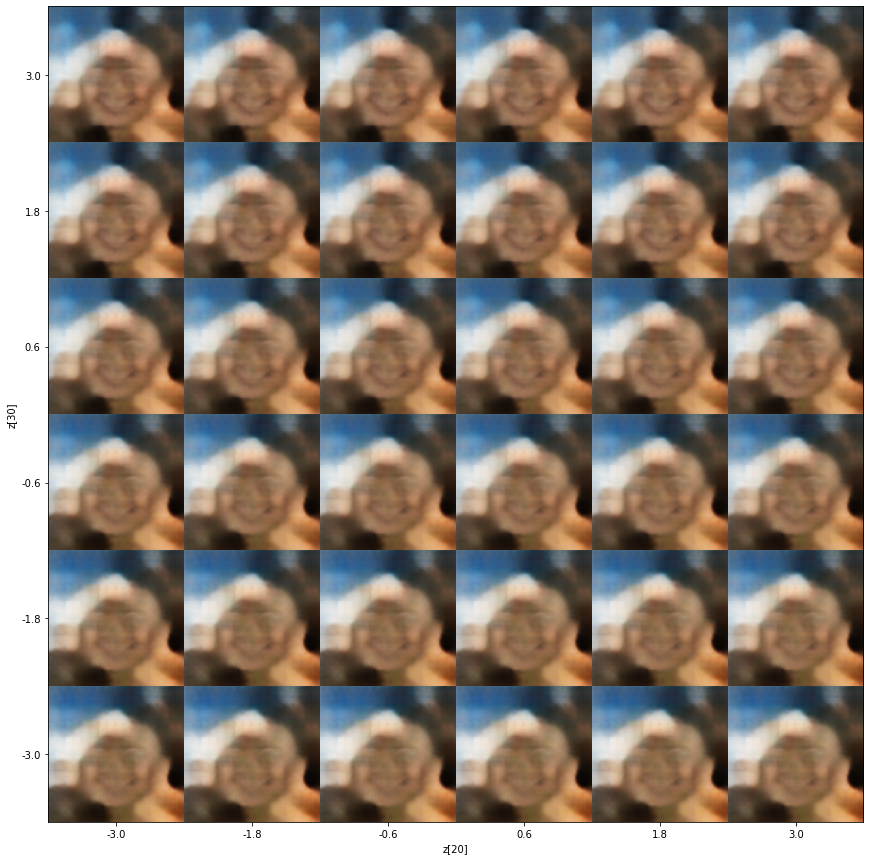

The person is5_o_Clock_Shadow
, and Arched_Eyebrows
, and Attractive
, and Bags_Under_Eyes
, and Bald
, and  NOT Bangs, and  NOT Big_Lips, and  NOT Big_Nose, and  NOT Black_Hair, and Blond_Hair
, and Blurry
, and  NOT Brown_Hair, and Bushy_Eyebrows
, and Chubby
, and Double_Chin
, and Eyeglasses
, and Goatee
, and  NOT Gray_Hair, and Heavy_Makeup
, and High_Cheekbones
, and  NOT Male, and Mouth_Slightly_Open
, and Mustache
, and  NOT Narrow_Eyes, and No_Beard
, and Oval_Face
, and  NOT Pale_Skin, and Pointy_Nose
, and Receding_Hairline
, and Rosy_Cheeks
, and Sideburns
, and Smiling
, and  NOT Straight_Hair, and  NOT Wavy_Hair, and  NOT Wearing_Earrings, and  NOT Wearing_Hat, and Wearing_Lipstick
, and Wearing_Necklace
, and Wearing_Necktie
, and  NOT Young, and 


In [ ]:
plot_latent_space(vae2, input_size=INPUT_DIM, n = 6, latents_start=[20,30], scale=3)

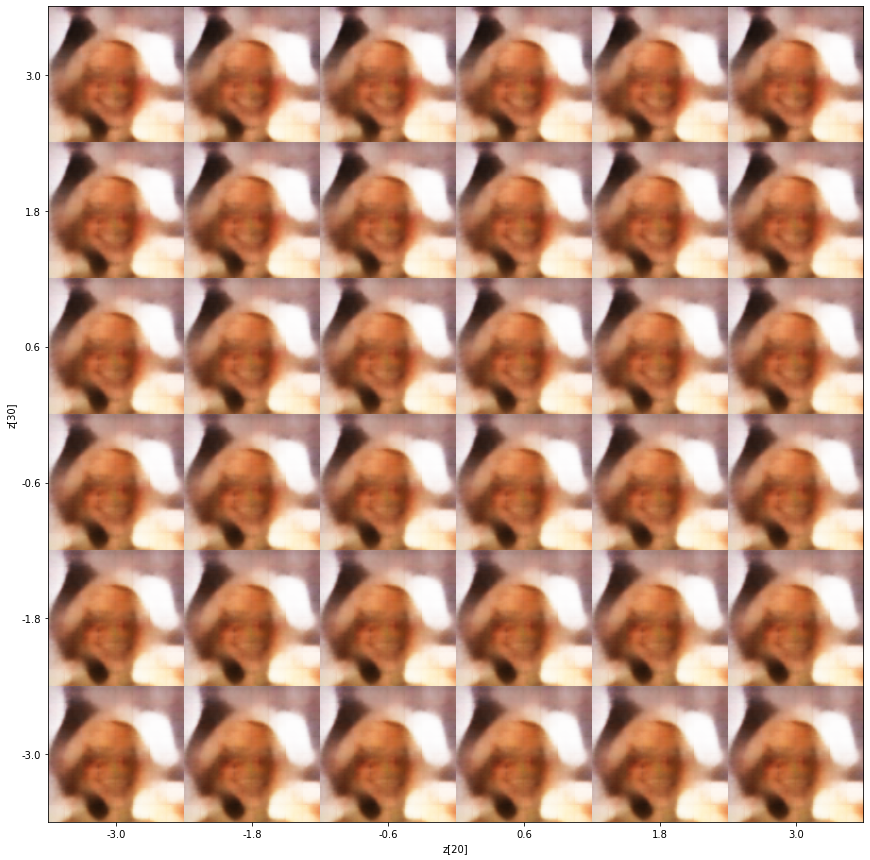

The person is5_o_Clock_Shadow
, and Arched_Eyebrows
, and Attractive
, and Bags_Under_Eyes
, and Bald
, and  NOT Bangs, and  NOT Big_Lips, and  NOT Big_Nose, and  NOT Black_Hair, and Blond_Hair
, and Blurry
, and  NOT Brown_Hair, and Bushy_Eyebrows
, and Chubby
, and Double_Chin
, and Eyeglasses
, and Goatee
, and  NOT Gray_Hair, and Heavy_Makeup
, and High_Cheekbones
, and  NOT Male, and Mouth_Slightly_Open
, and Mustache
, and  NOT Narrow_Eyes, and No_Beard
, and Oval_Face
, and  NOT Pale_Skin, and Pointy_Nose
, and Receding_Hairline
, and Rosy_Cheeks
, and Sideburns
, and Smiling
, and  NOT Straight_Hair, and  NOT Wavy_Hair, and  NOT Wearing_Earrings, and  NOT Wearing_Hat, and Wearing_Lipstick
, and Wearing_Necklace
, and Wearing_Necktie
, and  NOT Young, and 


In [ ]:
plot_latent_space(vae2, input_size=INPUT_DIM, n = 6, latents_start=[20,30], scale=3)

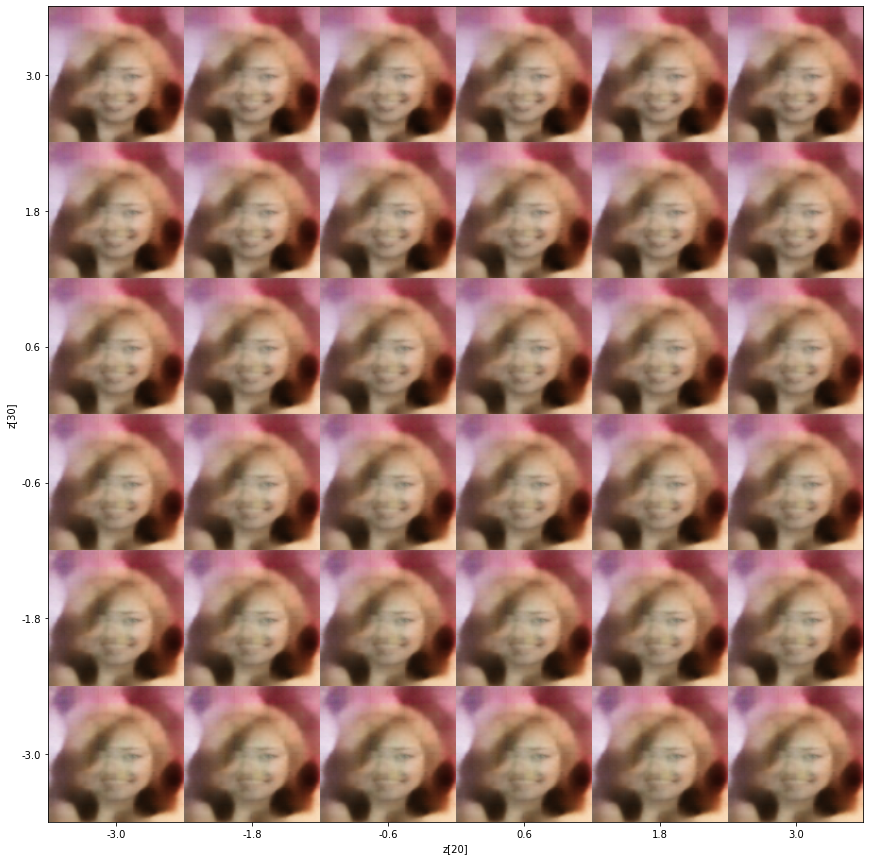

The person is5_o_Clock_Shadow
, and Arched_Eyebrows
, and Attractive
, and Bags_Under_Eyes
, and Bald
, and  NOT Bangs, and  NOT Big_Lips, and  NOT Big_Nose, and  NOT Black_Hair, and Blond_Hair
, and Blurry
, and  NOT Brown_Hair, and Bushy_Eyebrows
, and Chubby
, and Double_Chin
, and Eyeglasses
, and Goatee
, and  NOT Gray_Hair, and Heavy_Makeup
, and High_Cheekbones
, and  NOT Male, and Mouth_Slightly_Open
, and Mustache
, and  NOT Narrow_Eyes, and No_Beard
, and Oval_Face
, and  NOT Pale_Skin, and Pointy_Nose
, and Receding_Hairline
, and Rosy_Cheeks
, and Sideburns
, and Smiling
, and  NOT Straight_Hair, and  NOT Wavy_Hair, and  NOT Wearing_Earrings, and  NOT Wearing_Hat, and Wearing_Lipstick
, and Wearing_Necklace
, and Wearing_Necktie
, and  NOT Young, and 


In [ ]:
plot_latent_space(vae2, input_size=INPUT_DIM, n = 6, latents_start=[20,30], scale=3)

## **Comentarios:** Como observamos los rostros no tienen mucha definición esto puede ser porque el vae sólo se entrenó con 50 épocas. Quizá con las 400 originales pudiera haber un mejoría.

# Interpolación convexa de dos imágenes.

In [ ]:
images = merge_dataset.take(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  import sys


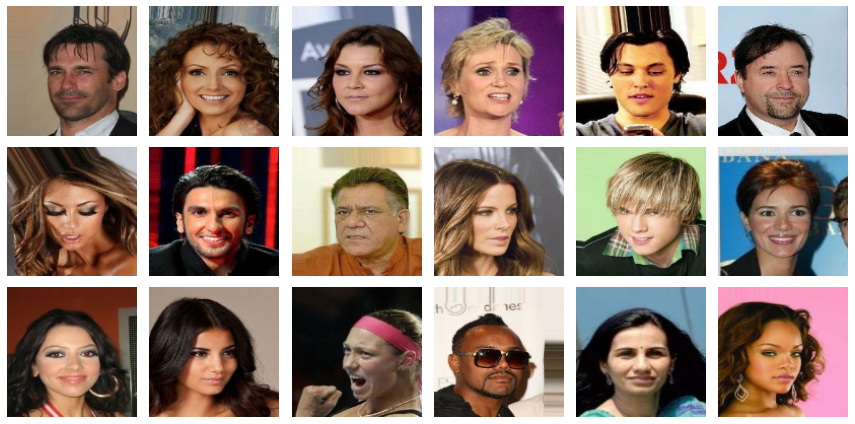

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6), tight_layout=True)

for images_, _ in images:
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images_[i].numpy())
        plt.axis('off')

plt.show() 

In [ ]:
for images_, labels_ in merge_dataset.take(10) :
    images = images_
    labels = labels_

In [ ]:
images.shape, labels.shape

(TensorShape([384, 128, 128, 3]), TensorShape([384, 40]))

In [ ]:
x = vae2.encoder_model.predict([images, labels])
print(x.shape)
z, z_mean, z_log_var = vae2.sampler_model(x)

(384, 160)


In [ ]:
z.shape, z_mean.shape, z_log_var.shape

(TensorShape([384, 160]), TensorShape([384, 160]), TensorShape([384, 160]))

In [ ]:
def plot_warping(z1, z2, n=(1,5)):
    
    n_trans = np.prod(n)

    f, axarr = plt.subplots(n[0],n[1], figsize=(10,6),  tight_layout=True)
    for i in range(n[0]):
        for j in range(n[1]):
            alpha = (i*n[1]+j)/(n_trans-1)
            z_new = (1-alpha)*z1 + alpha*z2
            z_new=tf.expand_dims(z_new, axis=0)
            label=random_label()
            x_decoded = vae.decoder_model([z_new, label])
            img = x_decoded[0].numpy()
            axarr[i,j].imshow(img)
            axarr[i,j].set_title("{:0.3}".format(alpha))
            axarr[i,j].axis('off')
    
    plt.show()

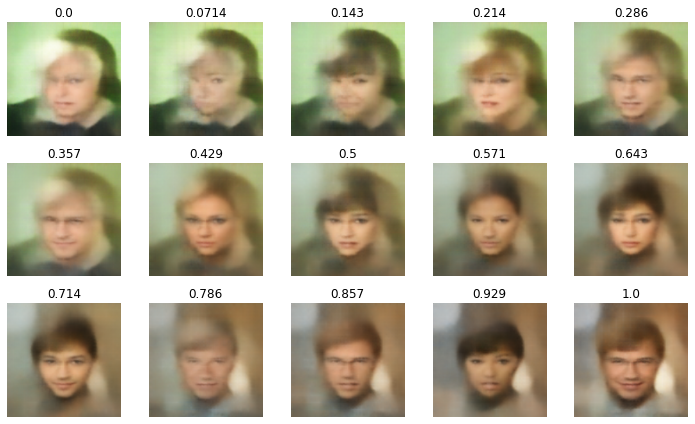

In [ ]:
plot_warping(z1=z_mean[10], z2=z_mean[20], n=(3,5))

# Revisamos la distribución de $\mathbb{P}(X)$

El objetivo de esta sección es revisar que efectivamente tenemos una distribución gaussiana.

In [ ]:
for i in range(5):
    for imagenes, etiquetas in merge_dataset.take(10) :
      imag = imagenes
      lab  = etiquetas
    x = vae2.encoder_model.predict([imag, lab])
    _, z_mean,_= vae2.sampler_model(x)
    if i:
        Z = np.concatenate((Z, z_mean), axis=0)
    else:
        Z = z_mean
        
Z = np.array(Z)
Z.shape

(1920, 160)

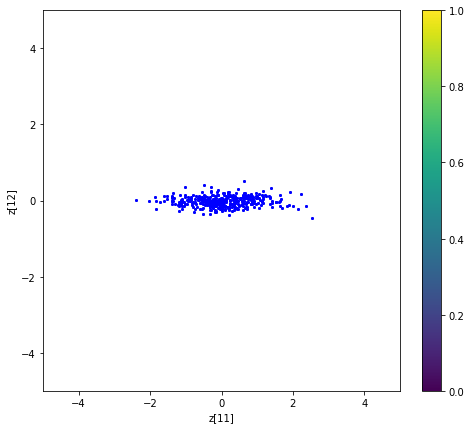

In [ ]:
def plot_label_clusters(xdata, ydata, limits=10):
    # display a 2D plot of the digit classes in the latent space
    plt.figure(figsize=(8,7))
    plt.scatter(xdata,ydata, s=(2,),c='b')
    plt.colorbar()
    plt.xlabel("z[11]")
    plt.ylabel("z[12]")
    plt.xlim([-limits,limits])
    plt.ylim([-limits,limits])
    plt.show()


xdata = Z[:,0]
ydata = Z[:,3]
plot_label_clusters(xdata=xdata, ydata=ydata, limits=5)

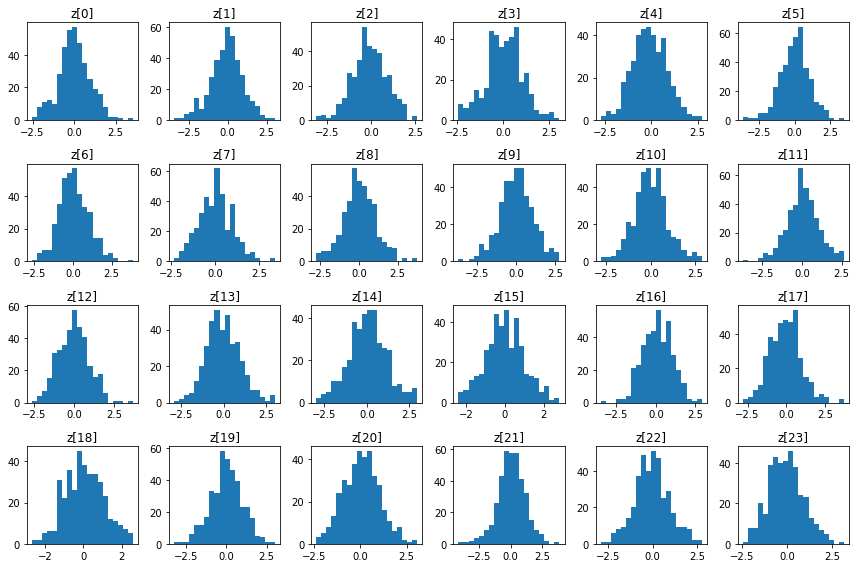

In [ ]:
nrows, ncols = 4,6
fig, axs = plt.subplots(nrows,ncols, figsize=(12,8), tight_layout=True)
n_bins = 20

for i in range(nrows):
    for j in range(ncols):
        idx = i*ncols+j
        vals = z[:,idx].numpy() 
        axs[i,j].hist(vals, bins=n_bins)
        axs[i,j].set_title("z[{}]".format(idx))

fig.tight_layout()
plt.show()